In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
# Utilities from utils.py
from utils import masked_mae, masked_binary_crossentropy, masked_accuracy
from utils import DataGen, kerasPlot

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras import backend as k
# Setup
%matplotlib inline
config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
k.tensorflow_backend.set_session(tf.Session(config=config))
np.random.seed(42)
tf.set_random_seed(42)

 ### Hyper-parameters

In [3]:
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

learning_rate = 0.00003
momentum = 0.3
optimizer = SGD(lr = learning_rate, momentum=momentum)
callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, verbose=1)] # decay learning rate on plateau
loss={'age':masked_mae, 'sex':masked_binary_crossentropy}
sex_loss_weight = 0.7
batch_size = 5
dropout_rate = 0.6
epochs = 40
loss_weights={'age': 1-sex_loss_weight, 'sex': sex_loss_weight}
metrics={'age':masked_mae, 'sex':masked_accuracy}

In [4]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Activation
from keras.layers import Input, BatchNormalization, SpatialDropout3D
from keras.models import Model

def Conv3D_model(input_shape):
    input_layer = Input(input_shape)
    prev_layer = input_layer
    for i in range(4):
        layer = Conv3D(filters=(i+1)*8, kernel_size=(3, 3, 3))(prev_layer)
        if i == 3:
            layer = SpatialDropout3D(dropout_rate)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPool3D(pool_size=(2, 2, 2))(layer)
        layer = BatchNormalization()(layer)
        prev_layer = layer
    
    flatten_layer = Flatten()(prev_layer)
    age_layer = Dense(units=1, activation='linear' , name='age')(flatten_layer)
    sex_layer = Dense(units=1, activation='sigmoid', name='sex')(flatten_layer)
    
    return Model(inputs=input_layer, outputs=[age_layer, sex_layer])

In [5]:
dg = DataGen('train.csv', './data')
dg_val = DataGen('validation.csv', './data')
print("Training Samples:", dg.total_samples, ",  Validation Samples:", dg_val.total_samples,)

Training Samples: 2994 ,  Validation Samples: 200


In [6]:
model = Conv3D_model(dg.shape+(1,)) # +(1,),single channel
model.compile(optimizer=optimizer,
              loss=loss,
              loss_weights=loss_weights,
              metrics=metrics)

In [7]:
#model.load_weights('Conv3D-weights.h5')
history = model.fit_generator(dg.generator(batch_size),
                              steps_per_epoch = np.ceil(dg.total_samples/batch_size),
                              epochs = epochs,
                              max_queue_size = 10,
                              validation_data=dg_val.generator(batch_size),
                              validation_steps = np.ceil(dg_val.total_samples/batch_size),
                              callbacks=callbacks,
                              verbose=1)

Epoch 1/40
599/599 [==============================] - 535s 893ms/step - loss: 2.3759 - age_loss: 7.1377 - sex_loss: 0.3351 - age_masked_mae: 7.1377 - sex_masked_accuracy: 0.8664 - val_loss: 1.6566 - val_age_loss: 4.8733 - val_sex_loss: 0.2780 - val_age_masked_mae: 4.8733 - val_sex_masked_accuracy: 0.9050
Epoch 2/40
599/599 [==============================] - 532s 888ms/step - loss: 1.9028 - age_loss: 5.7037 - sex_loss: 0.2738 - age_masked_mae: 5.7037 - sex_masked_accuracy: 0.9118 - val_loss: 1.4699 - val_age_loss: 4.2422 - val_sex_loss: 0.2817 - val_age_masked_mae: 4.2422 - val_sex_masked_accuracy: 0.9250
Epoch 3/40
599/599 [==============================] - 523s 874ms/step - loss: 1.7769 - age_loss: 5.3160 - sex_loss: 0.2601 - age_masked_mae: 5.3160 - sex_masked_accuracy: 0.9135 - val_loss: 1.4928 - val_age_loss: 4.3715 - val_sex_loss: 0.2591 - val_age_masked_mae: 4.3715 - val_sex_masked_accuracy: 0.9050
Epoch 4/40
599/599 [==============================] - 518s 865ms/step - loss: 1.69

Epoch 27/40
599/599 [==============================] - 537s 897ms/step - loss: 1.3499 - age_loss: 4.1054 - sex_loss: 0.1689 - age_masked_mae: 4.1054 - sex_masked_accuracy: 0.9467 - val_loss: 1.2571 - val_age_loss: 3.7142 - val_sex_loss: 0.2041 - val_age_masked_mae: 3.7142 - val_sex_masked_accuracy: 0.9250

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
Epoch 28/40
599/599 [==============================] - 532s 888ms/step - loss: 1.3461 - age_loss: 4.0911 - sex_loss: 0.1697 - age_masked_mae: 4.0911 - sex_masked_accuracy: 0.9482 - val_loss: 1.3001 - val_age_loss: 3.8623 - val_sex_loss: 0.2020 - val_age_masked_mae: 3.8623 - val_sex_masked_accuracy: 0.9250
Epoch 29/40
599/599 [==============================] - 524s 875ms/step - loss: 1.3341 - age_loss: 4.0537 - sex_loss: 0.1685 - age_masked_mae: 4.0537 - sex_masked_accuracy: 0.9513 - val_loss: 1.2597 - val_age_loss: 3.7262 - val_sex_loss: 0.2026 - val_age_masked_mae: 3.7262 - val_sex_masked_accuracy: 0.92

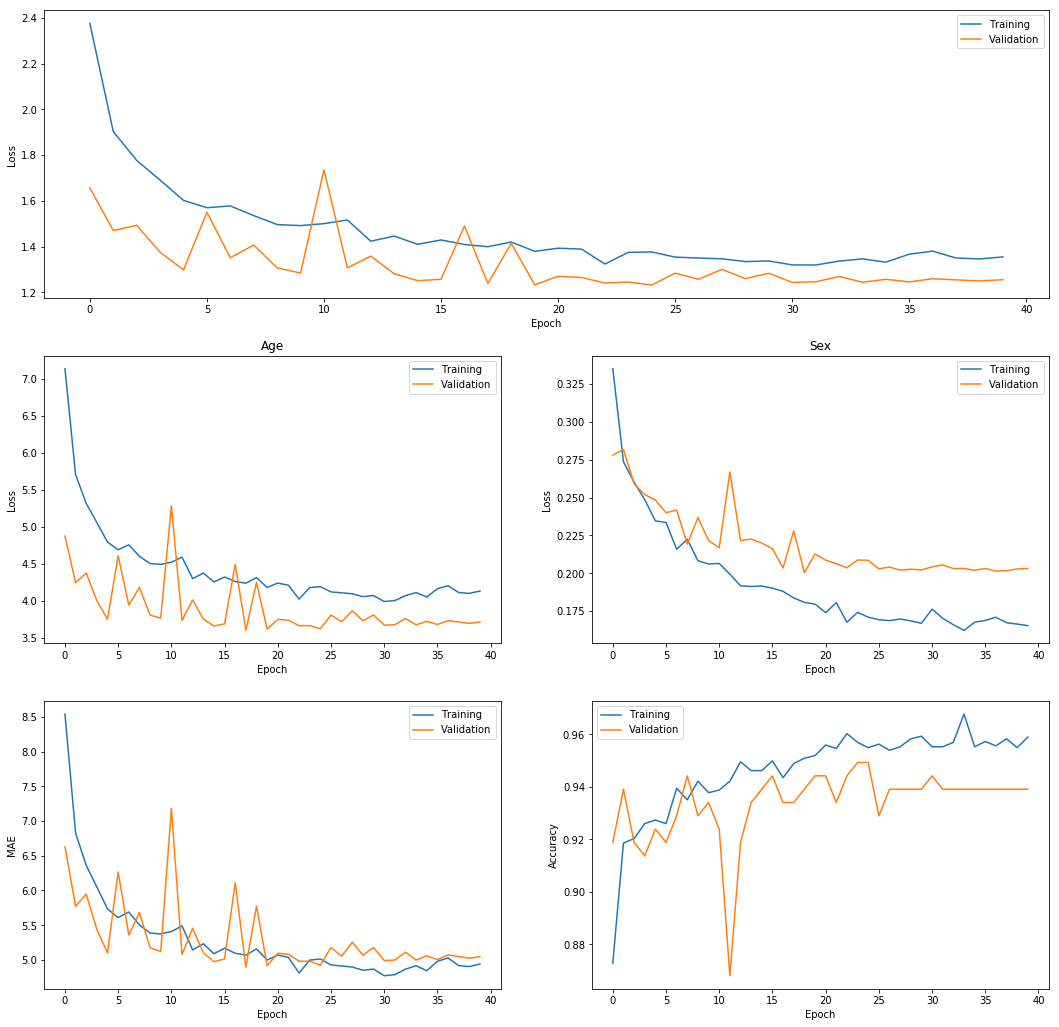

In [8]:
# Fix incorrectly calculated metrics
scale_age = dg.total_samples/np.sum(dg.age!=-1)
scale_sex = dg.total_samples/np.sum(dg.sex!=-1)
scale_val_age = dg_val.total_samples/np.sum(dg_val.age!=-1)
scale_val_sex = dg_val.total_samples/np.sum(dg_val.sex!=-1)
history.history["sex_masked_accuracy"] = np.multiply(scale_sex,history.history["sex_masked_accuracy"])
history.history["age_masked_mae"] = np.multiply(scale_age,history.history["age_masked_mae"])
history.history["val_sex_masked_accuracy"] = np.multiply(scale_val_sex,history.history["val_sex_masked_accuracy"])
history.history["val_age_masked_mae"] = np.multiply(scale_val_age,history.history["val_age_masked_mae"])

fig = kerasPlot(history)

In [9]:
from sklearn.metrics import accuracy_score, mean_absolute_error
dg_val = DataGen('validation.csv', './data')
IXI_val = DataGen('IXI_val.csv', './data')
OASIS_val = DataGen('OASIS3_val.csv', './data')
openfmri_val = DataGen('openfmri_val.csv', './data')

In [10]:
X,y = dg_val.getBatch(dg_val.total_samples)
age, sex = y
age_hat, sex_hat = model.predict(X, batch_size=5)
print("Age mean absolute error:",mean_absolute_error(age[ age!= -1], age_hat[ age!= -1] ))
print("Sex validation accuracy:",accuracy_score(sex[ sex!=-1 ],sex_hat[ sex!=-1 ]>.5 ))

Age mean absolute error: 5.0464973
Sex validation accuracy: 0.9390862944162437


In [11]:
X,y = IXI_val.getBatch(IXI_val.total_samples)
age, sex = y
age_hat, sex_hat = model.predict(X, batch_size=5)
print("IXI age mean absolute error:",mean_absolute_error(age[ age!= -1], age_hat[ age!= -1] ))
print("IXI sex validation accuracy:",accuracy_score(sex[ sex!=-1 ],sex_hat[ sex!=-1 ]>.5 ))

IXI age mean absolute error: 7.161507
IXI sex validation accuracy: 0.94


In [12]:
X,y = OASIS_val.getBatch(OASIS_val.total_samples)
age, sex = y
age_hat, sex_hat = model.predict(X, batch_size=5)
print("OASIS age not available" if np.all(age==-1) else "ERROR")
print("OASIS sex validation accuracy:",accuracy_score(sex[ sex!=-1],sex_hat[ sex!=-1]>.5))

OASIS age not available
OASIS sex validation accuracy: 0.98


In [13]:
X,y = openfmri_val.getBatch(openfmri_val.total_samples)
age, sex = y
age_hat, sex_hat = model.predict(X, batch_size=5)
print("openfmri age mean absolute error:",mean_absolute_error(age[ age!= -1], age_hat[ age!= -1] ))
print("openfmri sex validation accuracy:",accuracy_score(sex[ sex!=-1],sex_hat[ sex!=-1]>.5))

openfmri age mean absolute error: 3.9562867
openfmri sex validation accuracy: 0.9175257731958762


In [14]:
model.save_weights('Conv3D-weights.h5')
fig.savefig('Conv3D-curves.pdf')
import pickle
with open('Conv3D-history.pickle', 'wb') as file:
    pickle.dump(history.history, file)